## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

1. Oczyść dane i zaprezentuj rozkład klas

In [1]:
import pandas as pd
import seaborn as sns
import spacy
import re
from wordcloud import WordCloud
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split

c:\Users\Administrator\Desktop\-NLP-Stress-Identification\StressEnv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = pd.read_csv('Stress.csv')
data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [4]:
cols_to_drop = ['subreddit','post_id','sentence_range','confidence','social_timestamp']
df = data.drop(cols_to_drop,axis=1)
df.sample(5)

,text,label
2354,I recieved an eviction notice on 8/28/17 I hav...,1
1400,It's unfortunate we can't crosspost links from...,0
305,"By contributing to my fund, you are investing ...",0
1564,I was left to hold the burden of explaining to...,1
1866,"But we didn't talk about it the morning after,...",0


In [5]:
df['label'].unique()

array([1, 0], dtype=int64)

In [6]:
df.groupby('label').nunique()

,text
label,
0,1338
1,1485


<AxesSubplot:xlabel='label', ylabel='count'>

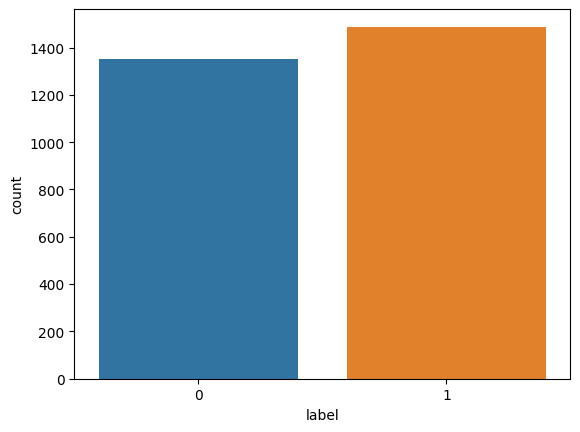

In [7]:
sns.countplot(x='label', data=df)

In [8]:
df['text'] = df['text'].apply(lambda x: x.lower())
df.sample(5)

,text,label
616,if you are triggered stop reading but the word...,1
158,"\tit was the summer, i had just started a new ...",0
2427,i need help talking about this: you can still ...,1
2207,"apparently with this new technology, my entire...",1
397,she says she's sorry and that she would never ...,1


In [9]:
re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
df['text'] = df['text'].apply(lambda x: re_url.sub('', x))

re_letter = re.compile(r"[^a-z\s']")
df['text'] = df['text'].apply(lambda x: re_letter.sub('', x))
df.sample(10)

,text,label
1165,theyve only kissed twice but ive read their te...,1
228,posttext don't bother with this part that's cr...,0
340,cant wait to reach that phase i stopped by a s...,0
797,hes claiming i beat him in that fight i had to...,1
343,he would play really loud music on the speaker...,1
521,can you contribute your story alongside others...,0
1796,no we do not have sex everyday yes we both wor...,0
576,i recently went through an event that was extr...,1
546,and i found as i got older i always turned to ...,0
2655,tw sexual abuse mentions when i was i was sex...,1


In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [10]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('sentencizer')

In [11]:
def remove_stopwords(text):
  return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

df['text'] = df['text'].apply(remove_stopwords)
df.sample(10)

,text,label
389,haven't posted probably experienced ptsd isola...,1
812,suddenly family wished appease fh youngest 'fl...,0
297,asshole know makes simply can't heart relation...,1
228,posttext don't bother that's crossed wasn't th...,0
2018,sorry bad english weeks i've cut social intera...,1
2376,feel like i've failed having fear i've rape tr...,1
2189,suffered concussion month ago noticed provoked...,1
1559,rational believes i'm retroactively terrified ...,1
894,ask local representative help steps haven't i'...,1
258,recover great deal conflict scared remember ye...,1


In [12]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [13]:
def lemmatize(text):
  return ' '.join([x.lemma_ for x in nlp(text)])

df['text'] = df['text'].progress_apply(lemmatize)
df.sample(10)

100%|██████████| 2818/2818 [00:35<00:00, 79.19it/s]


,text,label
666,lead talk person want person b want relationsh...,0
432,hi sorry ask today mums birthday month have no...,1
1074,shortly anxiety set totally unfamiliar feeling...,1
26,do not know I m wonder I m able fear traumatic...,1
281,quick background leave guy year turn possessio...,0
119,know going maybe think it be suboxone thing he...,1
820,needless lie dsssocial service like worry safe...,1
1606,consume morbid curiosity I be constantly rwatc...,0
1667,I be long time lurker rrelationship post lock ...,0
8,actually assistant half emergency fee come hel...,1


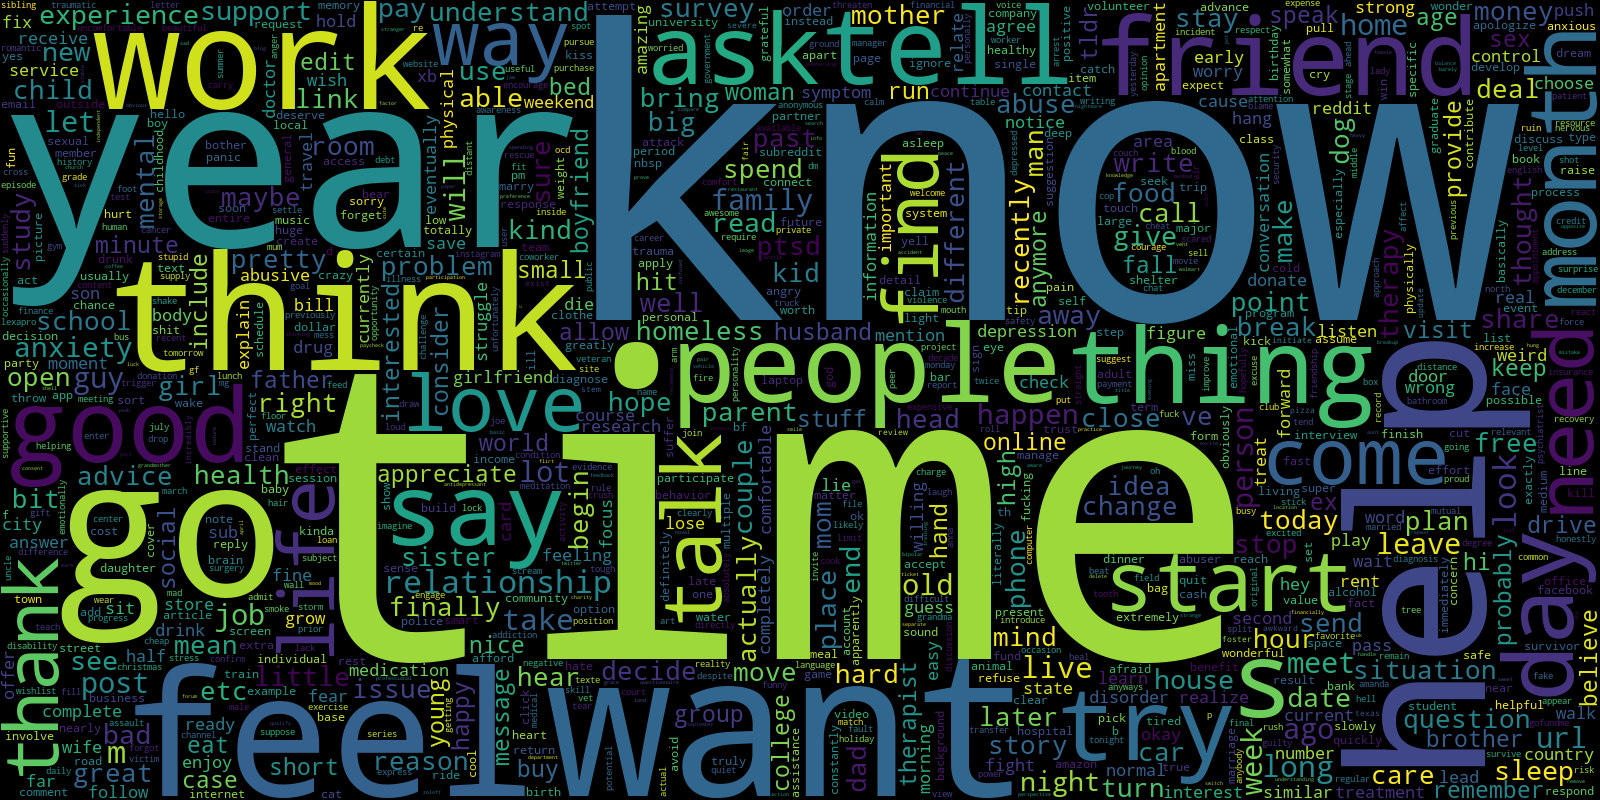

In [47]:
no_stress = ' '.join(df[df['label']==0]['text'])

wc_no_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(no_stress)
wc_no_stress.to_image()

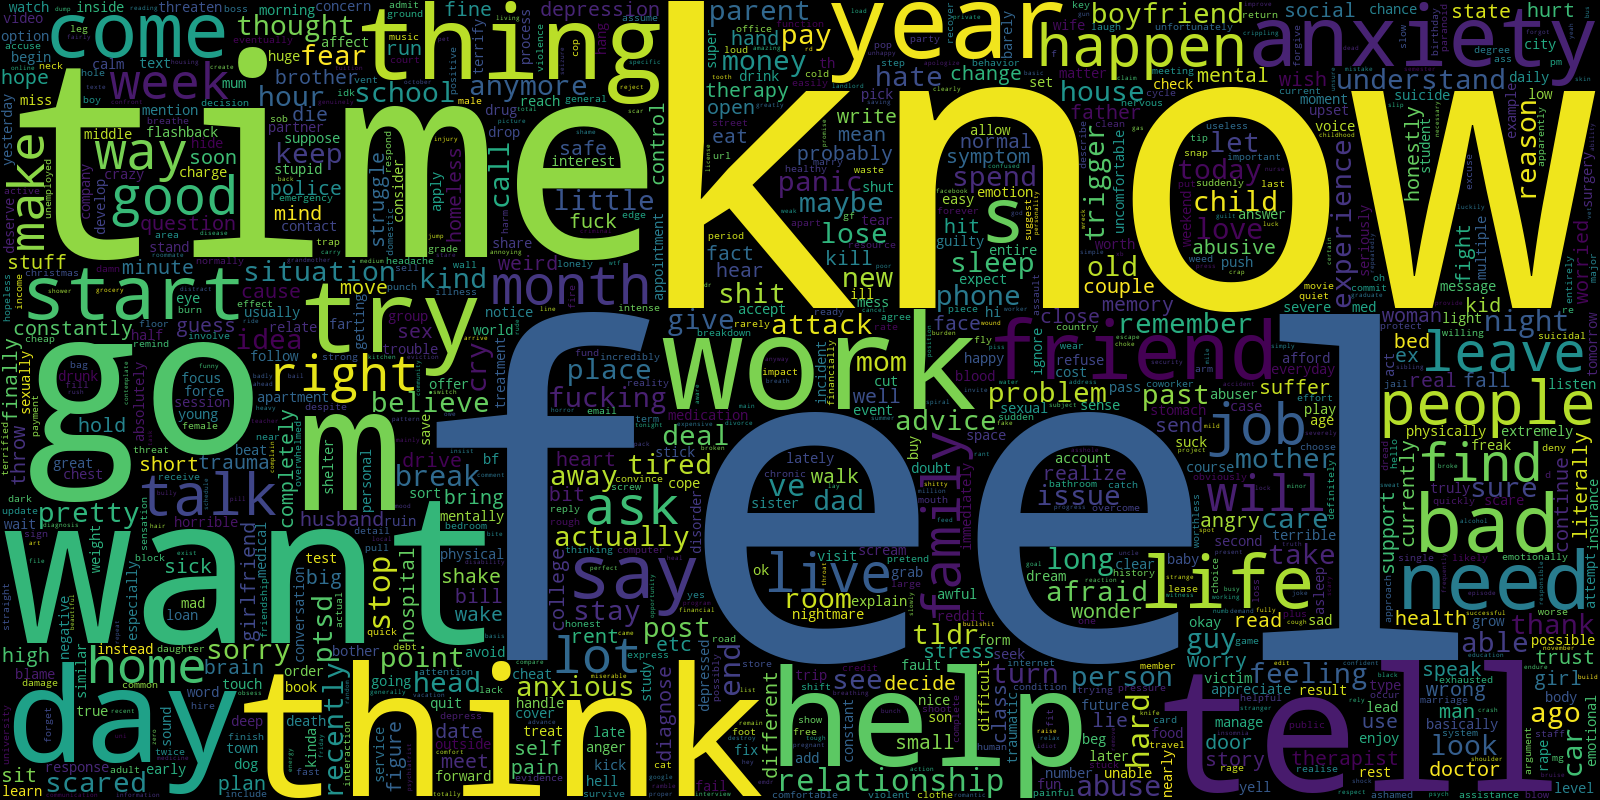

In [48]:
stress = ' '.join(df[df['label']==1]['text'])

wc_stress = WordCloud(max_words=1000, width = 1600, height = 800, collocations=False).generate(stress)
wc_stress.to_image()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus,n,g):
  vec=CountVectorizer(ngram_range=(g,g)).fit(corpus)
  bag_of_words=vec.transform(corpus)
  sum_words=bag_of_words.sum(axis=0)
  words_freq=[(word,sum_words[0,idx]) for word ,idx in vec.vocabulary_.items()]
  words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True)
  return words_freq[:n]

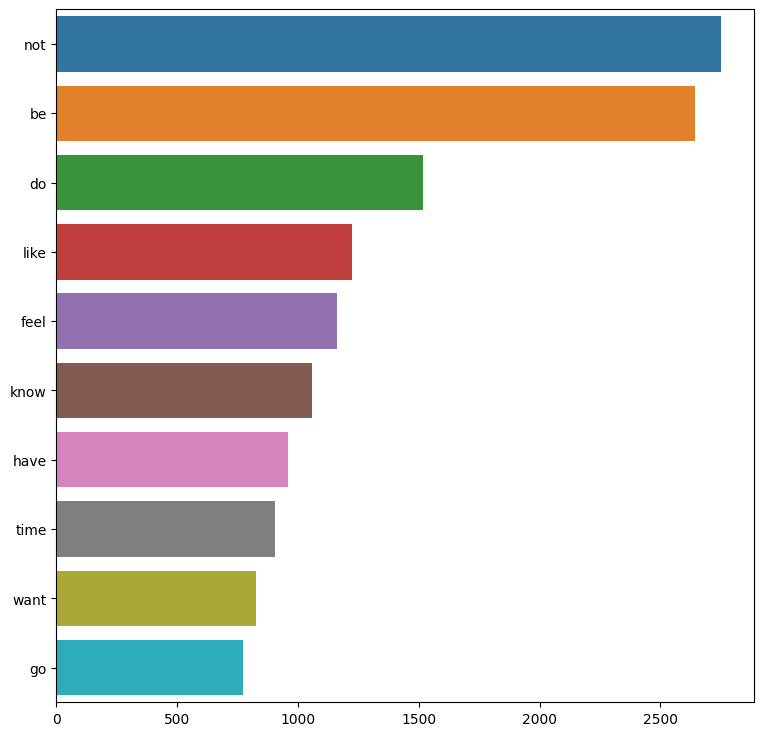

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 9))
most_common_uni = get_top_text_ngrams(df.text, 10, 1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))
plt.show()


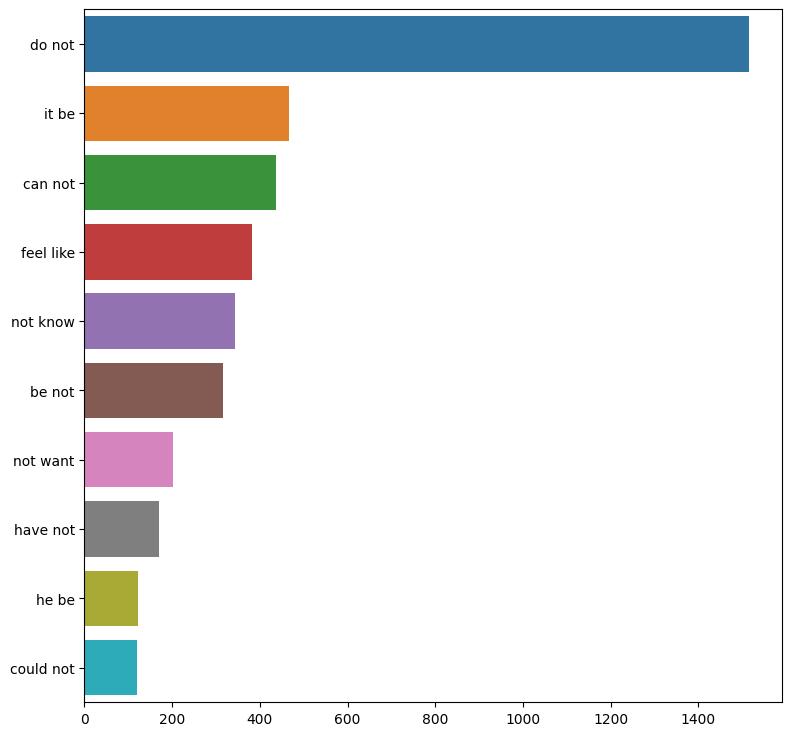

In [16]:
plt.figure(figsize=(9, 9))
most_common_uni = get_top_text_ngrams(df.text, 10, 2)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()), y=list(most_common_uni.keys()))
plt.show()

2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN <---
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

In [17]:
X_train,X_val,y_train,y_val=train_test_split(df.text,df.label,test_size=0.1,random_state=42)

In [18]:
X_train.shape,y_train.shape

((2536,), (2536,))

In [19]:
X_val.shape,y_val.shape

((282,), (282,))

In [20]:
max_features=1000
maxlen=300

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text

tokenizer=text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train=tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(tokenized_train,maxlen=maxlen)

In [22]:
type(X_train)

numpy.ndarray

In [23]:
X_val = [str(x) for x in X_val]

In [24]:
tokenized_test=tokenizer.texts_to_sequences(X_val)
X_val=pad_sequences(tokenized_test,maxlen=maxlen)

In [25]:
type(X_val)

numpy.ndarray

Sieć Rekurencyjna (LSTM/GRU/sieć dwukierunkowa) inna niż podstawowe RNN

In [57]:
batch_size=256
epochs=9
embed_size=100

In [58]:
from keras.callbacks import ReduceLROnPlateau

learning_rate=ReduceLROnPlateau(monitor='val_accuracy',
                                patirnce=2,verbose=1,factor=-.5,min_lr=0.00001)

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
import keras


model=Sequential()
model.add(Embedding(max_features,output_dim=embed_size,
                    input_length=maxlen,trainable=False))
model.add(LSTM(units=128,return_sequences=True,recurrent_dropout=0.25,dropout=0.25))
model.add(LSTM(units=64,recurrent_dropout=0.1,dropout=0.1))
model.add(Dense(units=32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 100)          100000    
                                                                 
 lstm_8 (LSTM)               (None, 300, 128)          117248    
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 268,769
Trainable params: 168,769
Non-trainable params: 100,000
_________________________________________________________________


In [60]:
lstm_model=model.fit(X_train,y_train,batch_size=batch_size,
                  validation_data=(X_val,y_val),epochs=epochs,
                  callbacks=[learning_rate])

Epoch 1/9
10/10 [==============================] - 168s 16s/step - loss: 0.7033 - accuracy: 0.5556 - val_loss: 0.7079 - val_accuracy: 0.5319 - lr: 0.0100
Epoch 2/9
10/10 [==============================] - 160s 16s/step - loss: 0.6801 - accuracy: 0.5722 - val_loss: 0.6700 - val_accuracy: 0.5957 - lr: 0.0100
Epoch 3/9
10/10 [==============================] - 162s 16s/step - loss: 0.6595 - accuracy: 0.6037 - val_loss: 0.6307 - val_accuracy: 0.6348 - lr: 0.0100
Epoch 4/9
10/10 [==============================] - 163s 16s/step - loss: 0.6551 - accuracy: 0.6238 - val_loss: 0.6460 - val_accuracy: 0.6099 - lr: 0.0100
Epoch 5/9
10/10 [==============================] - 162s 16s/step - loss: 0.6269 - accuracy: 0.6463 - val_loss: 0.6286 - val_accuracy: 0.6277 - lr: 0.0100
Epoch 6/9
10/10 [==============================] - 163s 16s/step - loss: 0.6183 - accuracy: 0.6585 - val_loss: 0.6267 - val_accuracy: 0.6277 - lr: 0.0100
Epoch 7/9
10/10 [==============================] - 165s 16s/step - loss: 0.6

In [69]:
print(" Accuracy on Val data: ",model.evaluate(X_val,y_val)[1] *100 ,"%")

9/9 [==============================] - 2s 258ms/step - loss: 0.6253 - accuracy: 0.6560
 Accuracy on Val data:  65.60283899307251 %


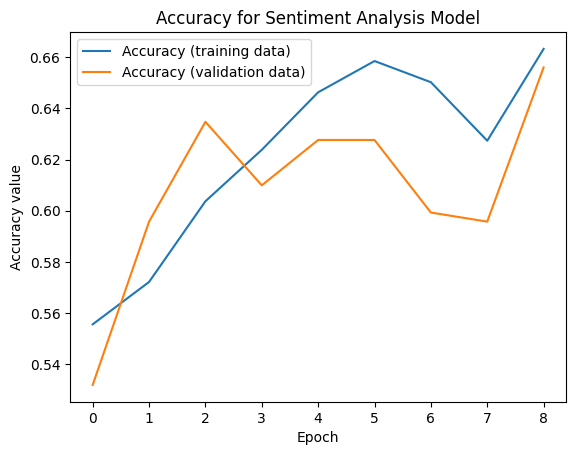

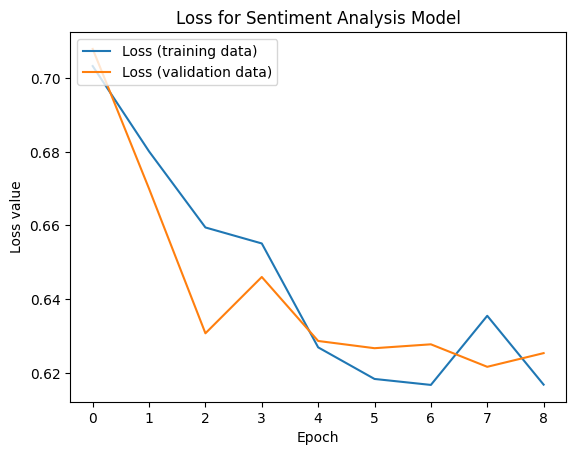

In [61]:
import matplotlib.pyplot as plt

plt.plot(lstm_model.history['accuracy'], label='Accuracy (training data)')
plt.plot(lstm_model.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy for Sentiment Analysis Model')
plt.ylabel('Accuracy value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(lstm_model.history['loss'], label='Loss (training data)')
plt.plot(lstm_model.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Sentiment Analysis Model')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

In [62]:
def prepare_sentence(sentence):

    sentence = sentence.lower()

    re_url = re.compile(r'((www.[^\s]+)|(https?://[^\s]+))')
    sentence = re_url.sub('', sentence)

    re_letter = re.compile(r"[^a-z\s']")
    sentence = re_letter.sub('', sentence)

    def remove_stopwords(text):
        return ' '.join(filter(lambda x: x not in nlp.Defaults.stop_words, text.split()))

    sentence = remove_stopwords(sentence)

    def lemmatize(text):
        return ' '.join([x.lemma_ for x in nlp(text)])

    sentence = lemmatize(sentence)

    tokenized_sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(tokenized_sentence, maxlen=maxlen, padding='post')

    return sentence

In [63]:
def predict_sentiment(model, sentence):
    
    prepared_sentence = prepare_sentence(sentence)
    prediction = model.predict(prepared_sentence)

    if prediction >= 0.5:
        return "I can sense STRESS in this sentence" 
    else:
        return "All good don't sense ANY STRESS in here "

Wykorzystanie sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN

In [64]:
sentence = "I had a peaceful evening reading my favorite book."
result = predict_sentiment(model, sentence)
print(result)

1/1 [==============================] - 1s 629ms/step
All good don't sense ANY STRESS in here 
